In [11]:
import pandas as pd
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import igraph as ig
from scipy.sparse import csr_matrix

In [ ]:
datasets_name = ['peng' , 'steele', 'lin' , 'hwang', 'zhang', 'werba']
cell_mtx_dir = Path('/media/celia/data/cell_mtx/')

node_lists_ = {}
cells_lists_ = {}
sparse_matrices_ = {}

for dataset in datasets_name:
    sparse_data_path = cell_mtx_dir / f'cell_mtx_{dataset}_data.npz'
    if sparse_data_path.exists():
        data = np.load(sparse_data_path, allow_pickle=True)
        sparse_matrices_[dataset] = csr_matrix(data['sparse_matrix'].item())
        node_lists_[dataset] = data['node_index_map']
        cells_lists_[dataset] = data['cell_index_map']
    else:
        print(f"Warning: Sparse matrix file not found for dataset {dataset} at {sparse_data_path}")

def get_cell_barcodes(node):
    dataset = node.split('-')[-1]
    node_index_map = node_lists_[dataset]
    sparse_mtx = sparse_matrices_[dataset]
    cell_index_map = cells_lists_[dataset]
    if node not in node_index_map:
        raise ValueError(f"Node '{node}' not found in the index map")

    row_idx = np.where(node_index_map == node)[0][0]
    cells_indices = sparse_mtx[row_idx].nonzero()[1]
    cell_barcodes = cell_index_map[cells_indices]
    return cell_barcodes


# Filtering/cleaning clusters

In [ ]:
clustering_output =  pd.read_csv('/clustering_output.csv', sep = ',')

In [ ]:
cluster_cell_mapping = {}

for _, row in clustering_output.iterrows():
    node = row['Node']
    cluster = row['Cluster']
    cell_barcodes = get_cell_barcodes(node)
    
    if cluster not in cluster_cell_mapping:
        cluster_cell_mapping[cluster] = []
    cluster_cell_mapping[cluster].extend(cell_barcodes)
    
cell_cluster_counter = Counter()

for cluster, cell_barcodes in cluster_cell_mapping.items():
    for cell_barcode in cell_barcodes:
        cell_cluster_counter[cell_barcode] += 1

In [ ]:
cluster_node_mapping = {}
for _, row in clustering_output.iterrows():
    node = row['Node']
    cluster = row['Cluster']
    if cluster not in cluster_node_mapping:
        cluster_node_mapping[cluster] = []
    cluster_node_mapping[cluster].append(node)

In [ ]:
result = {}

for cluster, nodes in cluster_node_mapping.items():
    print(f"Processing cluster: {cluster}")

    # Group nodes by sample
    sample_to_nodes = {}
    for node in nodes:
        sample = node.split('_')[-1]
        if sample not in sample_to_nodes:
            sample_to_nodes[sample] = []
        sample_to_nodes[sample].append(node)

    # Check for nodes with common cells and retain the largest
    final_nodes = []
    for sample, sample_nodes in sample_to_nodes.items():
        if len(sample_nodes) > 1:
            nodes_to_consider = sample_nodes.copy()  
            for node1 in sample_nodes:
                node1_cells = get_cell_barcodes(node1)
                for node2 in sample_nodes:
                    if node1 != node2:
                        node2_cells = get_cell_barcodes(node2)
                        
                        # Check if the nodes share common cells
                        if len(set(node1_cells).intersection(node2_cells)) > 0:
                            cell_count1 = len(node1_cells)
                            cell_count2 = len(node2_cells)
                            
                            # Remove the smaller node from nodes_to_consider
                            if cell_count1 > cell_count2:
                                if node2 in nodes_to_consider:
                                    nodes_to_consider.remove(node2)
                            else:
                                if node1 in nodes_to_consider:
                                    nodes_to_consider.remove(node1) 
            final_nodes.extend(nodes_to_consider)
        else:
            final_nodes.extend(sample_nodes)

    result[cluster] = final_nodes


In [ ]:
data = []
for cluster, nodes in result.items():
    for node in nodes:
        data.append({'Node': node, 'Cluster': cluster})
df = pd.DataFrame(data, columns=['Node', 'Cluster'])
# df.to_csv('/clustering_output_filtered.csv', index=False)

# Clusters description

In [ ]:
clustering_output =  pd.read_csv('/clustering_output_filtered.csv', sep = ',')

In [ ]:
cluster_node_mapping = {}
for _, row in clustering_output.iterrows():
    node = row['Node']
    cluster = row['Cluster']
    if cluster not in cluster_node_mapping:
        cluster_node_mapping[cluster] = []
    cluster_node_mapping[cluster].append(node)

In [ ]:
def extract_nodes(nodes_list, pattern_list):
    """
    Extracts nodes from nodes_list that contain any of the patterns in pattern_list.

    Parameters:
    nodes_list (list): List of nodes (strings) to search from.
    pattern_list (list): List of patterns (strings) to match against.

    Returns:
    list: A list of nodes that contain any of the patterns.
    """
    extracted_nodes = [node for node in nodes_list if any(pattern in node for pattern in pattern_list)]
    return extracted_nodes

In [ ]:
def analyze_nodes(node_list):

    node_cell_mapping = {}
    for node in node_list:
        cells = get_cell_barcodes(node)
        node_cell_mapping[node] = set(cells)

    groups = []
    unique_nodes = set(node_list)

    for node1 in node_list:
        found_group = False
        for group in groups:
            # Check if node1 shares cells with any node in the group
            for node_in_group in group:
                common_cells = node_cell_mapping[node1].intersection(node_cell_mapping[node_in_group])
                if common_cells:
                    group.add(node1)  # Add node1 to the existing group
                    found_group = True
                    unique_nodes.discard(node1)  # Remove it from unique nodes
                    break  # No need to check further if it's already in the group
            if found_group:
                break
        
        if not found_group:
            # If node1 doesn't fit into any existing group, create a new group
            groups.append(set([node1]))

    common_node_count = len(set([node for group in groups for node in group if len(group) > 1]))

    different_node_count = len([group for group in groups if len(group) == 1])

    # Count the number of branch
    group_count = len([group for group in groups if len(group) > 1])

    return common_node_count, different_node_count, group_count

# print(f"Number of nodes with shared cells: {common_node_count}")
# print(f"Number of nodes with no common cells: {different_node_count}")
# print(f"Number of branch: {group_count}")

In [352]:
cluster_total = 0
single_dataset = 0
single_sample = 0
cluster_multiple = {}
cluster_pur_dataset = {}
cluster_pur_sample = {}
cluster_same_branch = {}
cluster_diff_branch = {}
cluster_branches = {}


for cluster, nodes in cluster_node_mapping.items():
    print(cluster)
    cluster_total += 1
    
    samples = []
    datasets = []
    for node in nodes:
        sample = node.split('_')[-1]
        samples.append(sample)
        dataset = sample.split('-')[-1]
        datasets.append(dataset)

    same_branch_tot = 0
    diff_branch_tot = 0
    branches_tot = 0
    multiple_sample = 0
    for sample in set(samples):
        if samples.count(sample) > 1:
            multiple_sample += 1
            common_sample_nodes = extract_nodes(nodes,[sample])
            same_branch, diff_branch, branches = analyze_nodes(common_sample_nodes)
            same_branch_tot += same_branch
            diff_branch_tot += diff_branch
            branches_tot += branches

    cluster_multiple[cluster] = multiple_sample
    cluster_same_branch[cluster] = same_branch_tot
    cluster_diff_branch[cluster] = diff_branch_tot
    cluster_branches[cluster] = branches_tot

    if len(set(datasets)) == 1 :
        single_dataset += 1
        cluster_pur_dataset[cluster] = True
    else:
        cluster_pur_dataset[cluster] = False

    if len(set(samples)) == 1:
        single_sample += 1
        cluster_pur_sample[cluster] = True
    else : 
        cluster_pur_sample[cluster] = False


C1
C2
C3
C4
C5
C6
C7
C8
C9
C10
C11
C12
C13
C14
C15
C16
C17
C18
C19
C20
C21
C22
C23
C24
C25
C26
C27
C28
C29
C30
C31
C32
C33
C34
C35
C36
C37
C38
C39
C40
C41
C42
C43
C44
C45
C46
C47
C48
C49
C50
C51
C52
C53
C54
C55
C56
C57
C58
C59
C60
C61
C62
C63
C64
C65
C66
C67
C68
C69
C70
C71
C72
C73
C74
C75
C76
C77
C78
C79
C80
C81
C82
C83
C84
C85
C86
C87
C88
C89
C90
C91
C92
C93
C94
C95
C96
C97
C98
C99
C100
C101
C102
C103
C104
C105
C106
C107
C108
C109
C110
C111
C112
C113
C114
C115
C116
C117
C118
C119
C120
C121
C122
C123
C124
C125
C126
C127
C128
C129
C130
C131
C132
C133
C134
C135
C136
C137
C138
C139
C140
C141
C142
C143
C144
C145
C146
C147
C148
C149
C150
C151
C152
C153
C154
C155
C156
C157
C158
C159
C160
C161
C162
C163
C164
C165
C166
C167
C168
C169
C170
C171
C172
C173
C174
C175
C176
C177
C178
C179
C180
C181
C182
C183
C184
C185
C186
C187
C188
C189
C190
C191
C192
C193
C194
C195
C196
C197
C198
C199
C200
C201
C202
C203
C204
C205
C206
C207
C208
C209
C210
C211
C212
C213
C214
C215
C216
C217
C218
C219
C220
C221
C22

In [353]:
print("Number of clusters : ",cluster_total)

print("Number of clusters containing only 1 dataset :", single_dataset, single_dataset / cluster_total )

print("Number of clusters containing only 1 sample :", single_sample)

Number of clusters :  426
Number of clusters containing only 1 dataset : 185 0.43427230046948356
Number of clusters containing only 1 sample : 0


In [ ]:
clusters_desc = {}

for key in cluster_node_mapping.keys():
    clusters_desc[key] = {
        'Number of Nodes' : len(cluster_node_mapping.get(key)),
        'Repeated Samples': cluster_multiple.get(key, None),
        'Single Dataset': cluster_pur_dataset.get(key, None),
        'Single Sample': cluster_pur_sample.get(key, None),
        'Same Branch': cluster_same_branch.get(key, None),
        'Different Branch': cluster_diff_branch.get(key, None),
        'Nummber of Branches': cluster_branches.get(key, None)
    }
    
clusers_df = pd.DataFrame.from_dict(clusters_desc, orient='index')
clusers_df.reset_index(inplace=True)
clusers_df.rename(columns={'level_0': 'Cluster'}, inplace=True)
clusers_df
# clusers_df.to_csv('/media/celia/data/ATLAS/clusters_description.csv')

# Cluster comparison description

In [ ]:
clustering_output =  pd.read_csv('/clustering_output_filtered.csv', sep = ',')

In [ ]:
cluster_node_mapping = {}
for _, row in clustering_output.iterrows():
    node = row['Node']
    cluster = row['Cluster']
    if cluster not in cluster_node_mapping:
        cluster_node_mapping[cluster] = []
    cluster_node_mapping[cluster].append(node)

Comparaison de 2 clusters en assignant un +1 dans la relation si un noeud se trouve en bas de l'autre noeud du 2ème cluster. (Pas de vérification si le lien entre les 2 noeuds sont direct) 

In [ ]:
total_same_sample = {}
total_samples_clst1 = {}
total_samples_clst2 = {}
same_branch_total = {}
diff_branch_total = {}
orientation1to2 = {}
orientation2to1 = {}


for i, clust1 in enumerate(list(cluster_node_mapping.keys())):
    # get nodes for cluster 1 and its samples
    clust1_nodes = cluster_node_mapping.get(clust1, [])
    samples1 = []
    for node in clust1_nodes:
        sample = node.split('_')[-1]
        samples1.append(sample)

    for clust2 in list(cluster_node_mapping.keys())[i+1:]:
        if clust1 != clust2:
            print(clust1, clust2)
            # get nodes for cluster 2 and its samples
            clust2_nodes = cluster_node_mapping.get(clust2,[])
            samples2 = []
            for node in clust2_nodes:
                sample = node.split('_')[-1]
                samples2.append(sample)
            
            # get the number of samples for the 2 clusters
            total_samples_clst1[(clust1,clust2)] = len(samples1)
            total_samples_clst2[(clust1,clust2)] = len(samples2)

            # get common samples between cluster 1 et 2
            common_samples = list(set(samples1) & set(samples2))
            nb_same_sample = len(common_samples) # Number of common samples
            total_same_sample[(clust1,clust2)] = nb_same_sample

            # compare the two clusters
            same_branch = 0
            diff_branch = 0
            clust1to2 = 0
            clust2to1 = 0

            for sample in common_samples :
                common_sample_nodes1 = extract_nodes(clust1_nodes,[sample])
                common_sample_nodes2 = extract_nodes(clust2_nodes,[sample])

                for node1 in common_sample_nodes1:
                    node1_cells = get_cell_barcodes(node1)
                    for node2 in common_sample_nodes2:
                        node2_cells = get_cell_barcodes(node2)
                        if len(set(node1_cells).intersection(node2_cells)) > 0:
                            same_branch += 1
                            if len(node1_cells) < len(node2_cells):
                                clust1to2 += 1
                            elif len(node1_cells) > len(node2_cells):
                                clust2to1 += 1
                        else :
                            diff_branch += 1

            same_branch_total[(clust1, clust2)] = same_branch
            diff_branch_total[(clust1, clust2)] = diff_branch
            orientation1to2[(clust1, clust2)] = clust1to2
            orientation2to1[(clust1, clust2)] = clust2to1


In [1476]:
combined_data = {}

ordered_keys = [(clust1, clust2) for i, clust1 in enumerate(list(cluster_node_mapping.keys())) for clust2 in list(cluster_node_mapping.keys())[i+1:]]

for key in ordered_keys:
    combined_data[key] = {
        'Cluster1 Samples': total_samples_clst1.get(key, None),
        'Cluster2 Samples': total_samples_clst2.get(key, None),
        'Number of Same Samples': total_same_sample.get(key, None),
        'Same Branch Total': same_branch_total.get(key, None),
        'Different Branch Total': diff_branch_total.get(key, None),
        'Cluster2 Parent': orientation1to2.get(key, None),
        'Cluster1 Parent': orientation2to1.get(key, None),
    }
df = pd.DataFrame.from_dict(combined_data, orient='index')
df.reset_index(inplace=True)
df.rename(columns={'level_0': 'Cluster1'}, inplace=True)
df.rename(columns={'level_1': 'Cluster2'}, inplace=True)
df

,Cluster1,Cluster2,Cluster1 Samples,Cluster2 Samples,Number of Same Samples,Same Branch Total,Different Branch Total,Cluster2 Parent,Cluster1 Parent
0,C2,C3,3,3,0,0,0,0,0
1,C2,C4,3,3,0,0,0,0,0
2,C2,C5,3,4,0,0,0,0,0
3,C2,C7,3,3,1,0,1,0,0
4,C2,C10,3,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
79795,C670,C677,10,5,1,1,0,0,1
79796,C670,C678,10,5,2,1,1,0,1
79797,C672,C677,3,5,1,0,1,0,0
79798,C672,C678,3,5,1,0,1,0,0


In [1477]:
# df.to_csv('/media/celia/data/atlas2/cluster_comparison.csv')

In the script clusters_pairwise_comparison.py, I compare clusters and assign +1 between the clusters if we find a direct link between 2 nodes (no intermediary nodes found in other clusters)

# Loading annotation

In [ ]:
clustering_output =  pd.read_csv('/clustering_output_filtered.csv', sep = ',')

In [ ]:
cluster_cell_mapping = {}

for _, row in clustering_output.iterrows():
    node = row['Node']
    cluster = row['Cluster']
    cell_barcodes = get_cell_barcodes(node)
    
    if cluster not in cluster_cell_mapping:
        cluster_cell_mapping[cluster] = []
    cluster_cell_mapping[cluster].extend(cell_barcodes)
    
cell_cluster_counter = Counter()

for cluster, cell_barcodes in cluster_cell_mapping.items():
    for cell_barcode in cell_barcodes:
        cell_cluster_counter[cell_barcode] += 1

In [ ]:
file_path = '/media/celia/data/annotation_broad.csv'
annotations_df = pd.read_csv(file_path, sep = ',')

In [ ]:
cell_annotation_map = {}
for _, row in annotations_df.iterrows():
    cell_annotation_map[row['cell_id']] = {
        'dataset': row['dataset'],
        'sctype_pred': row.get('sctype_pred'),
        'annotation': row.get('annotation'),
        'tumor': row.get('sample_type'),
        'treatment': row.get('treatment'),
    }

In [1135]:
from collections import Counter

broad_groups = {
    'Malignant': ['Malignant', 'EMT', 'ETC'],
    'Fibroblasts': ['myCAF', 'CAF', 'Fibroblast', 'Stellate'],
    'Endocrine': ['Endocrine', 'Alpha', 'Beta', 'Delta', 'Epsilon', 'Hormone-negative neuroendocrine', 'Gamma'],
    'Epithelial': ['Epithelial', 'Ductal_1', 'Ductal_2', 'Ductal (atypical)', 'Ductal', 'ADM', 'Acinar', 'Acinar (REG+)'], 
    'Ductal': ['Ductal_1', 'Ductal_2', 'Ductal (atypical)', 'Ductal'],
    'Acinar' : ['Acinar', 'Acinar (REG+)'],
    'Endothelial' : ['Lymphatic', 'Endothelial', 'Vascular', 'Pericyte', 'Vascular smooth muscle'],
    'Immune system cells': [
        'Macrophage', 'T_cell', 'Granulocyte', 'Dendritic', 'B_cell', 'Mast', 'Plasma', 
        'TIL', 'CD8+ T', 'CD4+ T', 'Treg (activated)', 'Natural killer', 'Dendritic (activated)', 
        'Treg', 'B', 'Neutrophil', 'Dendritic (plasmacytoid)', 'CD8+ T (terminally dysfunctional)', 
        'CD8+ T (dysfunctional)', 'CD8+ T (progenitor dysfunctional)', 
        'Dendritic (conventional type 1)', 'Dendritic (conventional type 2)', 'Treg (quiescent)'
    ],
    'Neuronal': ['Intra-pancreatic neurons', 'Schwann'],
    'Adipocyte' : ['Adipocyte']
}

def get_annotation(cell):
    if cell in cell_annotation_map:
        info = cell_annotation_map[cell]
        return info['sctype_pred'] if info['dataset'] != 'hwang' else info['annotation']
    
    cell_variants = [cell.replace(".", "-"), cell.replace(".", ":")]
    for cell_var in cell_variants:
        if cell_var in cell_annotation_map:
            return cell_annotation_map[cell_var]['sctype_pred']
        
    return None

def get_broader_annotation(cell):
    if cell in cell_annotation_map:
        info = cell_annotation_map[cell]
        if info['dataset'] == 'hwang':
            annotation = info['annotation']
            for broad_category, terms in broad_groups.items():
                if annotation in terms:
                    return broad_category
            return annotation 
        else:
            return info['sctype_pred']

    cell_variants = [cell.replace(".", "-"), cell.replace(".", ":")]
    for cell_var in cell_variants:
        if cell_var in cell_annotation_map:
            info = cell_annotation_map[cell_var]
            return info['sctype_pred'] if info['dataset'] != 'hwang' else info['annotation']

    return None



cluster_annotations = {}
different_annotations = set()

for clst, cells in cluster_cell_mapping.items():
    print(clst)
    cell_annot = [get_broader_annotation(cell) for cell in cells if get_broader_annotation(cell) is not None]
    different_annotations.update(cell_annot)
    
    total = len(cell_annot)
    annot_counts = Counter(cell_annot)
    annot_prop = {a: count / total for a, count in annot_counts.items()}
    cluster_annotations[clst] = annot_prop

C2
C3
C4
C5
C7
C10
C12
C13
C14
C19
C23
C30
C33
C35
C36
C40
C41
C43
C45
C46
C47
C49
C52
C53
C54
C55
C56
C58
C59
C60
C65
C67
C69
C72
C76
C81
C82
C83
C84
C85
C87
C96
C97
C98
C99
C101
C102
C103
C104
C105
C106
C107
C109
C110
C113
C114
C115
C117
C118
C120
C122
C123
C124
C125
C132
C133
C138
C139
C140
C141
C143
C145
C147
C150
C152
C154
C155
C157
C158
C160
C162
C163
C164
C165
C168
C172
C177
C178
C180
C187
C188
C190
C192
C194
C198
C199
C201
C202
C203
C205
C206
C207
C208
C209
C210
C211
C212
C219
C227
C228
C229
C230
C234
C237
C239
C241
C242
C243
C244
C245
C247
C248
C249
C250
C251
C252
C253
C254
C256
C257
C260
C261
C262
C267
C269
C270
C271
C272
C273
C274
C275
C276
C277
C278
C279
C280
C281
C282
C283
C284
C285
C286
C287
C288
C292
C294
C295
C298
C299
C302
C303
C311
C312
C313
C317
C318
C320
C321
C323
C324
C325
C326
C327
C328
C332
C333
C334
C335
C337
C338
C339
C340
C341
C342
C343
C344
C346
C347
C348
C351
C352
C353
C355
C356
C357
C358
C361
C362
C365
C366
C368
C373
C374
C375
C376
C378
C380
C381
C382
C383


In [1241]:
def get_tumor_type(cell):
    if cell in cell_annotation_map:
        info = cell_annotation_map[cell]
        return info['tumor']
    
    cell_variants = [cell.replace(".", "-"), cell.replace(".", ":")]
    for cell_var in cell_variants:
        if cell_var in cell_annotation_map:
            return cell_annotation_map[cell_var]['tumor']
        
    return None

cluster_annotations_tumor = {}
different_annotations_tumor = set()

for clst, cells in cluster_cell_mapping.items():
    print(clst)
    cell_annot = [get_tumor_type(cell) for cell in cells if get_tumor_type(cell) is not None]
    different_annotations_tumor.update(cell_annot)

    total = len(cell_annot)
    annot_counts = Counter(cell_annot)
    annot_prop = {a: count / total for a, count in annot_counts.items()}
    cluster_annotations_tumor[clst] = annot_prop

C2
C3
C4
C5
C7
C10
C12
C13
C14
C19
C23
C30
C33
C35
C36
C40
C41
C43
C45
C46
C47
C49
C52
C53
C54
C55
C56
C58
C59
C60
C65
C67
C69
C72
C76
C81
C82
C83
C84
C85
C87
C96
C97
C98
C99
C101
C102
C103
C104
C105
C106
C107
C109
C110
C113
C114
C115
C117
C118
C120
C122
C123
C124
C125
C132
C133
C138
C139
C140
C141
C143
C145
C147
C150
C152
C154
C155
C157
C158
C160
C162
C163
C164
C165
C168
C172
C177
C178
C180
C187
C188
C190
C192
C194
C198
C199
C201
C202
C203
C205
C206
C207
C208
C209
C210
C211
C212
C219
C227
C228
C229
C230
C234
C237
C239
C241
C242
C243
C244
C245
C247
C248
C249
C250
C251
C252
C253
C254
C256
C257
C260
C261
C262
C267
C269
C270
C271
C272
C273
C274
C275
C276
C277
C278
C279
C280
C281
C282
C283
C284
C285
C286
C287
C288
C292
C294
C295
C298
C299
C302
C303
C311
C312
C313
C317
C318
C320
C321
C323
C324
C325
C326
C327
C328
C332
C333
C334
C335
C337
C338
C339
C340
C341
C342
C343
C344
C346
C347
C348
C351
C352
C353
C355
C356
C357
C358
C361
C362
C365
C366
C368
C373
C374
C375
C376
C378
C380
C381
C382
C383


In [1238]:
different_annotations_tumor

{'Liver Metastase',
 'Metastasis',
 'PDAC liver met',
 'Primary PDAC',
 'Primary Tumor'}

In [1242]:
def get_dataset(cell):
    if cell in cell_annotation_map:
        info = cell_annotation_map[cell]
        return info['dataset']
    
    cell_variants = [cell.replace(".", "-"), cell.replace(".", ":")]
    for cell_var in cell_variants:
        if cell_var in cell_annotation_map:
            return cell_annotation_map[cell_var]['dataset']
        
    return None

cluster_annotations_dataset = {}
different_annotations_dataset = set()

for clst, cells in cluster_cell_mapping.items():
    print(clst)
    cell_annot = [get_dataset(cell) for cell in cells if get_dataset(cell) is not None]
    different_annotations_dataset.update(cell_annot)

    total = len(cell_annot)
    annot_counts = Counter(cell_annot)
    annot_prop = {a: count / total for a, count in annot_counts.items()}
    cluster_annotations_dataset[clst] = annot_prop

C2
C3
C4
C5
C7
C10
C12
C13
C14
C19
C23
C30
C33
C35
C36
C40
C41
C43
C45
C46
C47
C49
C52
C53
C54
C55
C56
C58
C59
C60
C65
C67
C69
C72
C76
C81
C82
C83
C84
C85
C87
C96
C97
C98
C99
C101
C102
C103
C104
C105
C106
C107
C109
C110
C113
C114
C115
C117
C118
C120
C122
C123
C124
C125
C132
C133
C138
C139
C140
C141
C143
C145
C147
C150
C152
C154
C155
C157
C158
C160
C162
C163
C164
C165
C168
C172
C177
C178
C180
C187
C188
C190
C192
C194
C198
C199
C201
C202
C203
C205
C206
C207
C208
C209
C210
C211
C212
C219
C227
C228
C229
C230
C234
C237
C239
C241
C242
C243
C244
C245
C247
C248
C249
C250
C251
C252
C253
C254
C256
C257
C260
C261
C262
C267
C269
C270
C271
C272
C273
C274
C275
C276
C277
C278
C279
C280
C281
C282
C283
C284
C285
C286
C287
C288
C292
C294
C295
C298
C299
C302
C303
C311
C312
C313
C317
C318
C320
C321
C323
C324
C325
C326
C327
C328
C332
C333
C334
C335
C337
C338
C339
C340
C341
C342
C343
C344
C346
C347
C348
C351
C352
C353
C355
C356
C357
C358
C361
C362
C365
C366
C368
C373
C374
C375
C376
C378
C380
C381
C382
C383


In [1243]:
different_annotations_dataset

{'hwang', 'lin', 'peng', 'steele', 'werba', 'zhang'}

In [1255]:
def get_treatment(cell):
    if cell in cell_annotation_map:
        info = cell_annotation_map[cell]
        return info['treatment']
    
    cell_variants = [cell.replace(".", "-"), cell.replace(".", ":")]
    for cell_var in cell_variants:
        if cell_var in cell_annotation_map:
            return cell_annotation_map[cell_var]['treatment']
        
    return None

cluster_annotations_treatment = {}
different_annotations_treatment = set()

for clst, cells in cluster_cell_mapping.items():
    print(clst)
    cell_annot = [get_treatment(cell) for cell in cells if get_treatment(cell) is not None]
    different_annotations_treatment.update(cell_annot)

    total = len(cell_annot)
    annot_counts = Counter(cell_annot)
    annot_prop = {a: count / total for a, count in annot_counts.items()}
    cluster_annotations_treatment[clst] = annot_prop

C2
C3
C4
C5
C7
C10
C12
C13
C14
C19
C23
C30
C33
C35
C36
C40
C41
C43
C45
C46
C47
C49
C52
C53
C54
C55
C56
C58
C59
C60
C65
C67
C69
C72
C76
C81
C82
C83
C84
C85
C87
C96
C97
C98
C99
C101
C102
C103
C104
C105
C106
C107
C109
C110
C113
C114
C115
C117
C118
C120
C122
C123
C124
C125
C132
C133
C138
C139
C140
C141
C143
C145
C147
C150
C152
C154
C155
C157
C158
C160
C162
C163
C164
C165
C168
C172
C177
C178
C180
C187
C188
C190
C192
C194
C198
C199
C201
C202
C203
C205
C206
C207
C208
C209
C210
C211
C212
C219
C227
C228
C229
C230
C234
C237
C239
C241
C242
C243
C244
C245
C247
C248
C249
C250
C251
C252
C253
C254
C256
C257
C260
C261
C262
C267
C269
C270
C271
C272
C273
C274
C275
C276
C277
C278
C279
C280
C281
C282
C283
C284
C285
C286
C287
C288
C292
C294
C295
C298
C299
C302
C303
C311
C312
C313
C317
C318
C320
C321
C323
C324
C325
C326
C327
C328
C332
C333
C334
C335
C337
C338
C339
C340
C341
C342
C343
C344
C346
C347
C348
C351
C352
C353
C355
C356
C357
C358
C361
C362
C365
C366
C368
C373
C374
C375
C376
C378
C380
C381
C382
C383


In [1257]:
different_annotations_treatment

{'CRT', 'CRTl', 'Other', 'Treated', 'Untreated'}

# Establishing hierarchy

## FIRST IDEA

### Code

In [13]:
clusters_comp = pd.read_csv('/media/celia/data/atlas2/cluster_comparison.csv', index_col=0)
clusters_comp

,Cluster1,Cluster2,Cluster1 Samples,Cluster2 Samples,Cluster2 Parent,Cluster1 Parent
0,C2,C3,3,3,0,0
1,C2,C4,3,3,0,0
2,C2,C5,3,4,0,0
3,C2,C7,3,3,0,0
4,C2,C10,3,3,0,0
...,...,...,...,...,...,...
79795,C670,C677,11,5,0,1
79796,C670,C678,11,5,0,1
79797,C672,C677,3,5,0,0
79798,C672,C678,3,5,0,0


Trying to establish hierarchy by starting with root parents and going down with the children, get the max value each time to choose the parent(s) for each children cluster.

In [14]:
def get_parents_n0(clusters_comp):
    """Get parent clusters without children."""
    all_clusters = pd.unique(clusters_comp[['Cluster1', 'Cluster2']].values.ravel('K'))
    children_clusters = set(clusters_comp.loc[
        (clusters_comp['Cluster1 Parent'] != 0) | (clusters_comp['Cluster2 Parent'] != 0),
        'Cluster1'
    ].where(clusters_comp['Cluster1 Parent'] < clusters_comp['Cluster2 Parent']).dropna().tolist() +
    clusters_comp.loc[
        (clusters_comp['Cluster1 Parent'] != 0) | (clusters_comp['Cluster2 Parent'] != 0),
        'Cluster2'
    ].where(clusters_comp['Cluster1 Parent'] > clusters_comp['Cluster2 Parent']).dropna().tolist())
    return set(all_clusters) - children_clusters

def get_children_of_parent(clusters_comp, parent):
    """Get children clusters for a given parent cluster."""
    temp = clusters_comp[
        (~((clusters_comp['Cluster1 Parent'] == 0) & (clusters_comp['Cluster2 Parent'] == 0))) & (
        ((clusters_comp['Cluster1'] == parent) & (clusters_comp['Cluster1 Parent'] >= clusters_comp['Cluster2 Parent'])) |
        ((clusters_comp['Cluster2'] == parent) & (clusters_comp['Cluster2 Parent'] >= clusters_comp['Cluster1 Parent'])))
    ]
    return np.where(temp['Cluster1'] == parent, temp['Cluster2'], temp['Cluster1']).tolist()

def get_rows_to_delete(temp, child, parent_clusters):
    rows_to_delete = temp[
            ~(((temp['Cluster1'] == child) & (temp['Cluster2'].isin(parent_clusters))) |
              ((temp['Cluster2'] == child) & (temp['Cluster1'].isin(parent_clusters))))
        ].index
    return rows_to_delete


def get_new_parents(clusters_comp, children):
    """Map new parents for each child cluster and return updated clusters_comp after deleting irrelevant rows."""
    new_parent = {}
    rows_to_delete = []

    for child in children:
        temp = clusters_comp[
            ~((clusters_comp['Cluster1 Parent'] == 0) & (clusters_comp['Cluster2 Parent'] == 0)) & (
            ((clusters_comp['Cluster1'] == child) & (clusters_comp['Cluster2 Parent'] >= clusters_comp['Cluster1 Parent'])) |
            ((clusters_comp['Cluster2'] == child) & (clusters_comp['Cluster1 Parent'] >= clusters_comp['Cluster2 Parent'])))
        ]
        
        # Find max parent value for this child
        max_parent_value = temp[['Cluster1 Parent', 'Cluster2 Parent']].max().max()

        # Map child to its parent clusters
        parent_clusters = np.concatenate([
            temp[temp['Cluster1'] == child].loc[temp['Cluster2 Parent'] == max_parent_value, 'Cluster2'].values,
            temp[temp['Cluster2'] == child].loc[temp['Cluster1 Parent'] == max_parent_value, 'Cluster1'].values
        ]).tolist()

        rows_to_delete.extend(get_rows_to_delete(temp, child, parent_clusters))
        new_parent[child] = parent_clusters

    # Remove irrelevant rows from clusters_comp
    updated_clusters_comp = clusters_comp.drop(rows_to_delete)
    return new_parent, updated_clusters_comp


In [15]:
clusters_comp_copy = clusters_comp.copy()
all_clusters = pd.unique(clusters_comp[['Cluster1', 'Cluster2']].values.ravel('K'))
parents_n0 = get_parents_n0(clusters_comp_copy)
root_parents = len(parents_n0)

link2 = dict()
while len(link2) < len(all_clusters) - root_parents:
    print('Iteration')
    children = set()
    for p in parents_n0:
        children.update(get_children_of_parent(clusters_comp_copy, p))

    if not children:
        print("No more children to process, exiting the loop.")
        break

    # Get new parents and updated clusters_comp_copy
    new_parent, clusters_comp_copy = get_new_parents(clusters_comp_copy, children)
    link2.update(new_parent)

    # Update parents for next iteration
    parents_n0 = {k for k, v in new_parent.items() if any(parent in parents_n0 for parent in v)}

    if not parents_n0:
        print("No more new parents, exiting the loop.")
        break


Iteration
Iteration
Iteration
Iteration
Iteration


In [16]:
# Changing from children -> parent to parent -> children
result_tuples = [(key, value) for key, values in link2.items() for value in values]
edges = [(v, k) for k, v in result_tuples]

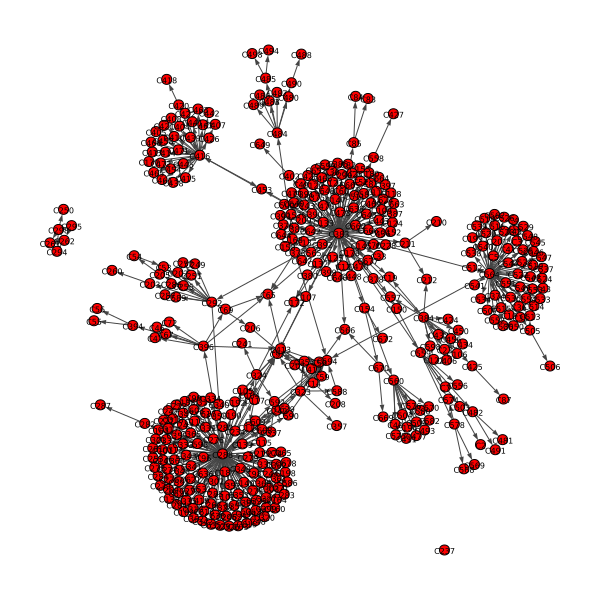

In [18]:
# NO PREDEFINED LAYOUT

all_clusters = pd.unique(clusters_comp[['Cluster1', 'Cluster2']].values.ravel('K'))

g = ig.Graph(directed=True)

g.add_vertices(all_clusters)

g.add_edges(edges)

ig.plot(
    g, 
    vertex_size=10,
    edge_arrow_size=0.5,
    margin=50,
    vertex_label=g.vs["name"],
    vertex_label_size = 8,
    # bbox=(0, 0, 1000, 1000),
)


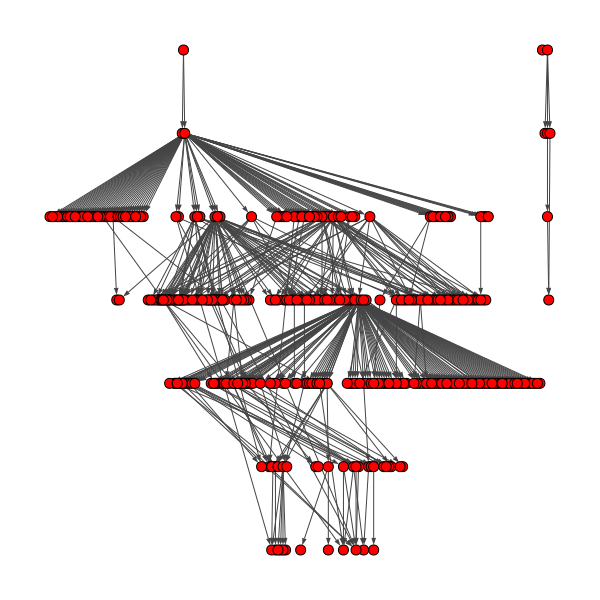

In [1007]:
# SUGIYAMA LAYOUT (HIERARCHICAL)
g = ig.Graph(directed=True)


g.add_vertices(all_clusters)

g.add_edges(edges)

layout = g.layout_sugiyama()

ig.plot(
    g, 
    layout=layout,
    vertex_size=10,
    edge_arrow_size=0.5,
    margin=50
)

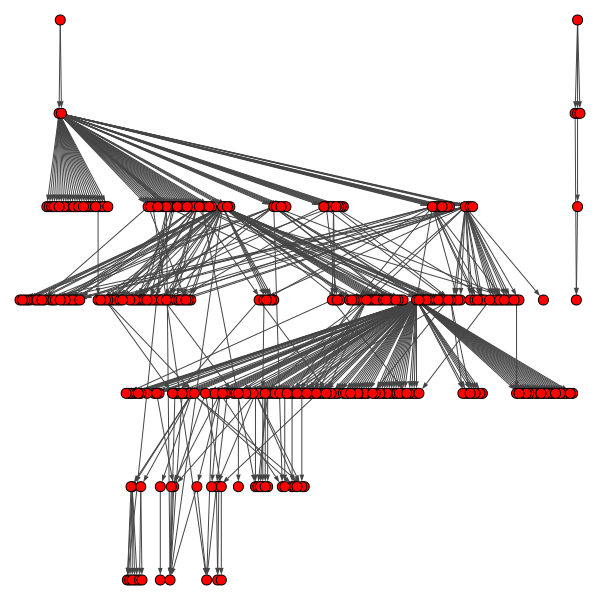

In [1013]:
# If no cycles in the graph, use transitive_reduction of networkx 

import networkx as nx

        
g = nx.DiGraph(edges)

TR = nx.transitive_reduction(g)

nodes = list(TR.nodes())
edges = list(TR.edges())

g_ig = ig.Graph(directed=True)

g_ig.add_vertices(nodes)

g_ig.add_edges(edges)

layout = g_ig.layout_sugiyama()

ig.plot(
    g_ig,
    layout=layout,
    vertex_size=10,
    edge_arrow_size=0.5,
    margin=20
    )


### PLOTS

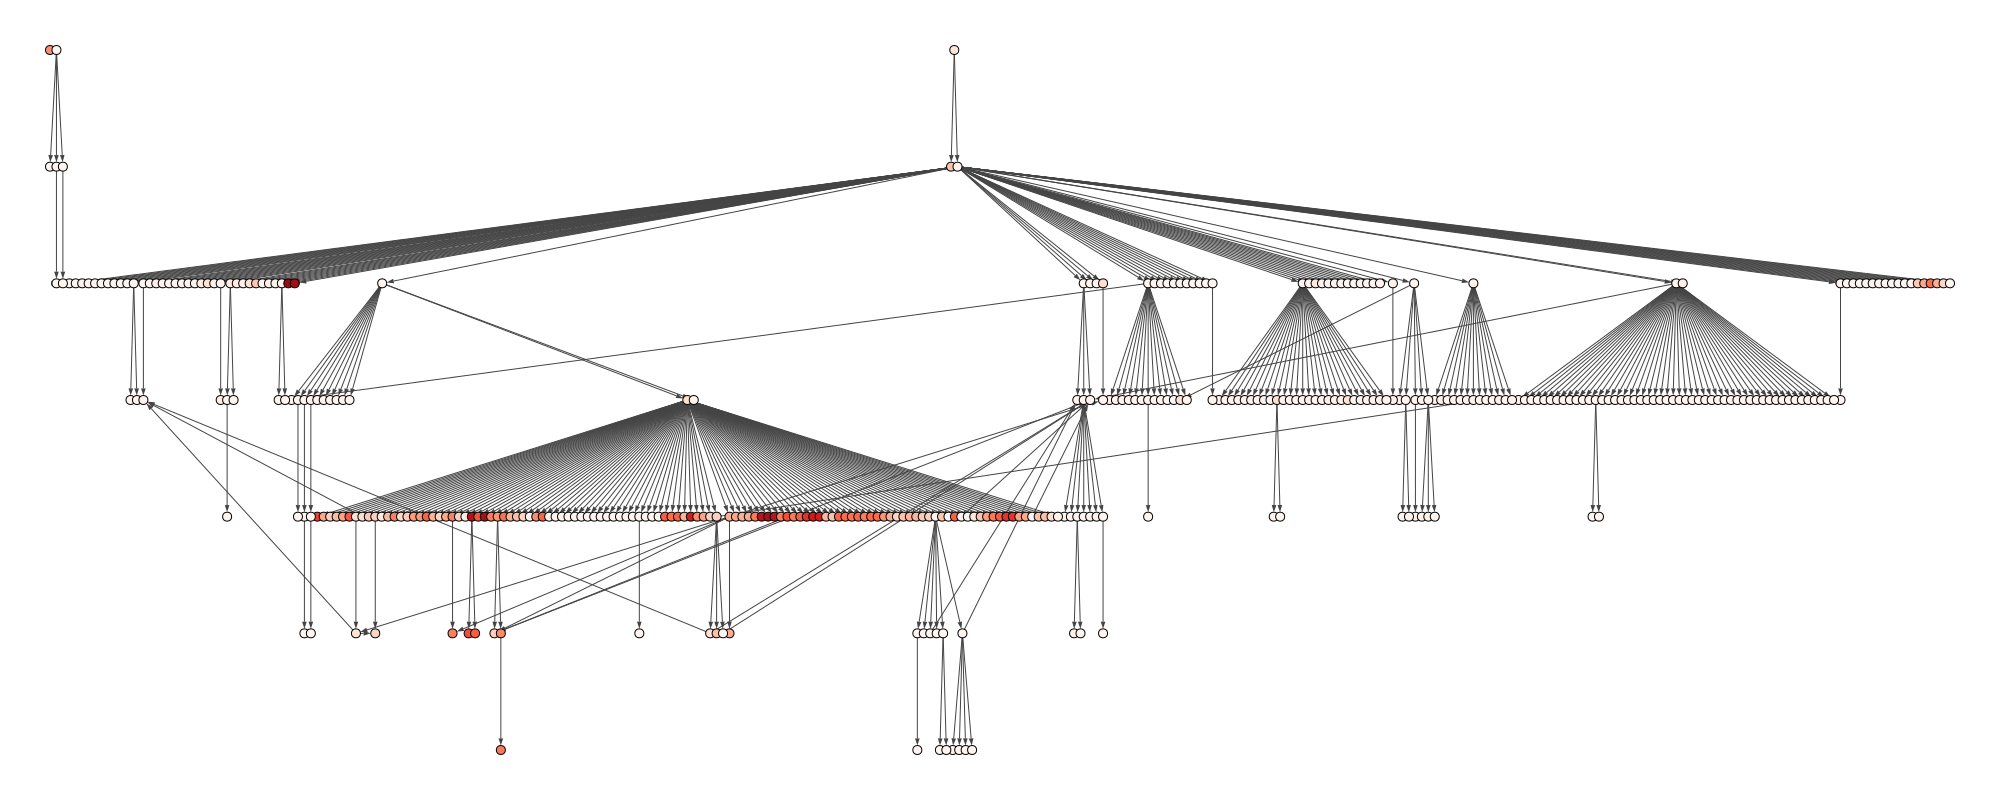

In [1261]:
g = ig.Graph(directed=True)
g.add_vertices(all_clusters)
g.add_edges(edges)
layout = g.layout_reingold_tilford()
annotations = ['Ductal', 'Ductal cells']
proportions = [
    sum(cluster_annotations[clst].get(ann, 0) for ann in annotations)
    for clst in cluster_annotations
]
cmap = plt.get_cmap('Reds')
colors = [cmap(prop) for prop in proportions]
colors_hex = ['#' + ''.join(f'{int(c * 255):02X}' for c in color[:3]) for color in colors]

ig.plot(
    g, 
    layout=layout,
    vertex_color=colors_hex,
    vertex_size=9,
    edge_arrow_size=0.5,
    margin=50,
    # vertex_label_size = 8,
    bbox=(0, 0, 2000, 800),
    
)

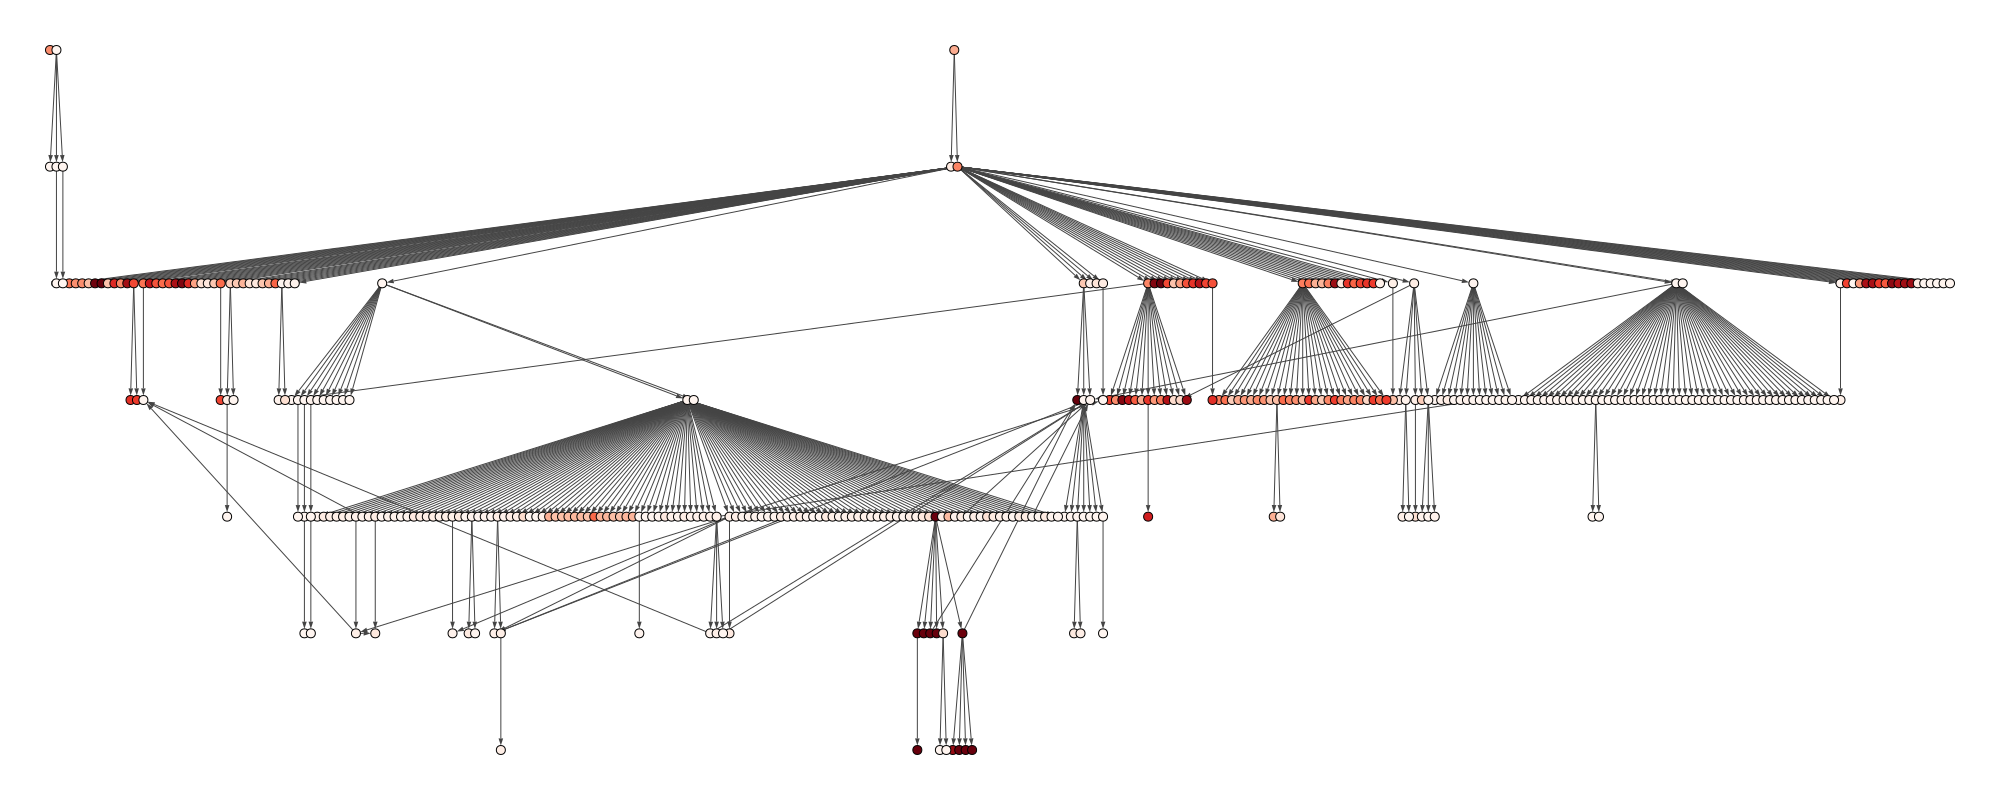

In [1229]:
g = ig.Graph(directed=True)
g.add_vertices(all_clusters)
g.add_edges(edges)
layout = g.layout_reingold_tilford()
annotations = ['Immune system cells', 'Mast cells']
proportions = [
    sum(cluster_annotations[clst].get(ann, 0) for ann in annotations)
    for clst in cluster_annotations
]
cmap = plt.get_cmap('Reds')
colors = [cmap(prop) for prop in proportions]
colors_hex = ['#' + ''.join(f'{int(c * 255):02X}' for c in color[:3]) for color in colors]

ig.plot(
    g, 
    layout=layout,
    vertex_color=colors_hex,
    vertex_size=9,
    edge_arrow_size=0.5,
    margin=50,
    # vertex_label_size = 8,
    bbox=(0, 0, 2000, 800),
    
)


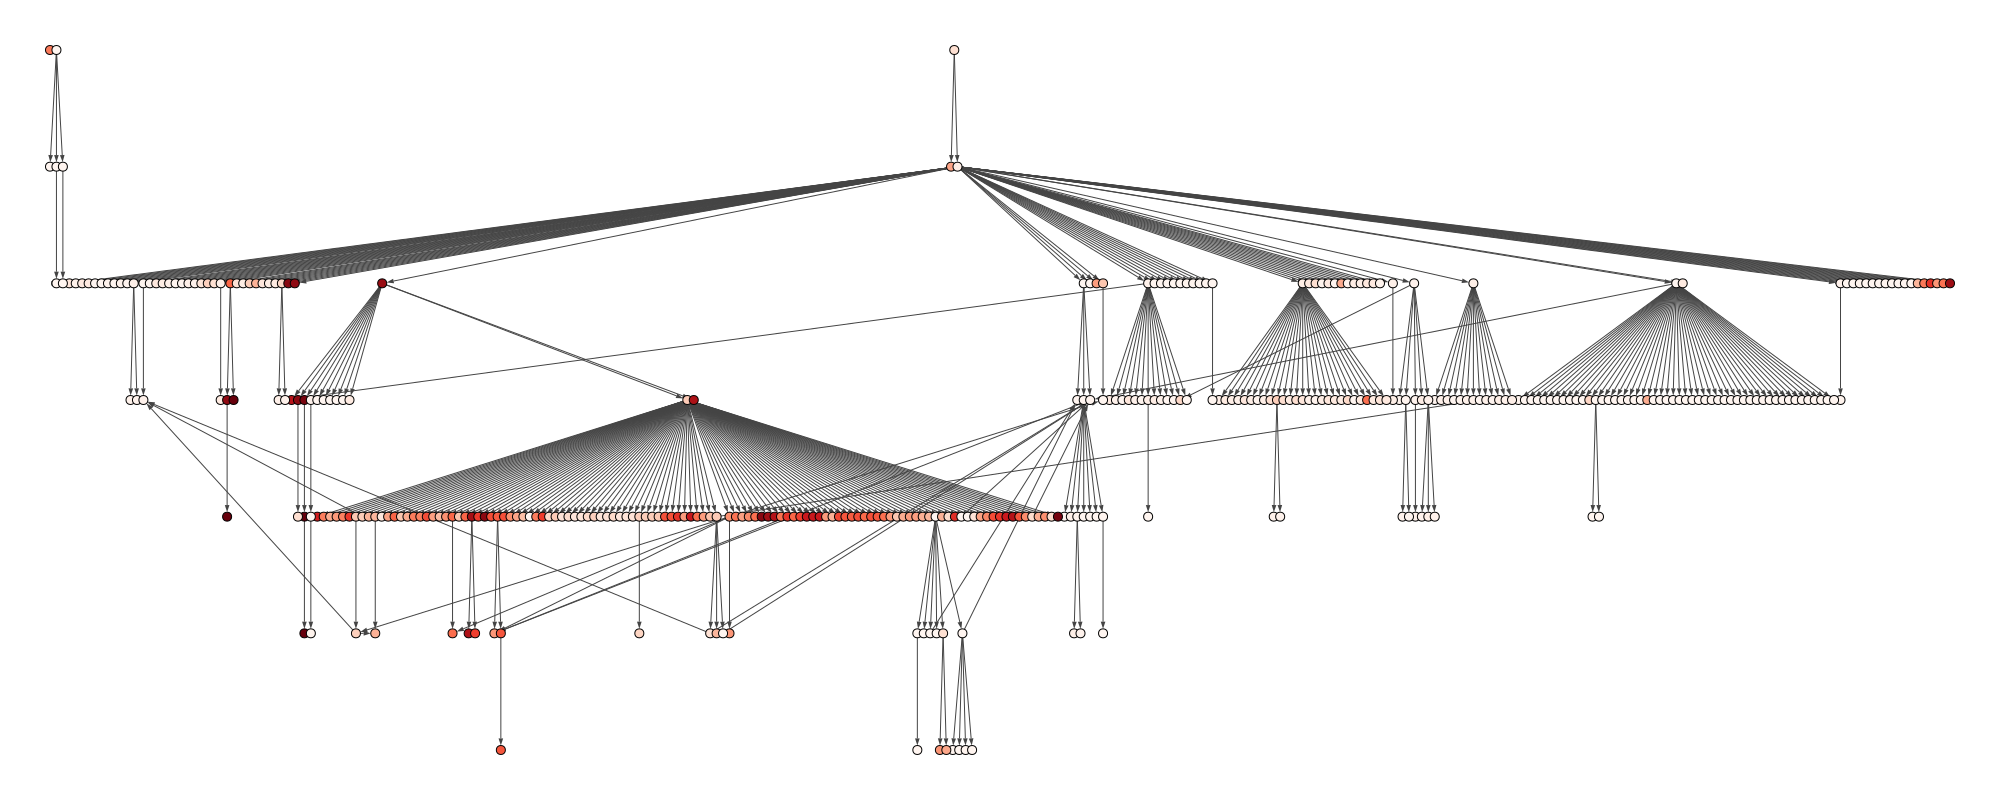

In [1227]:
g = ig.Graph(directed=True)
g.add_vertices(all_clusters)
g.add_edges(edges)
layout = g.layout_reingold_tilford()
annotations = ['Epithelial', 'Acinar cells', 'Ductal cells']
proportions = [
    sum(cluster_annotations[clst].get(ann, 0) for ann in annotations)
    for clst in cluster_annotations
]
cmap = plt.get_cmap('Reds')
colors = [cmap(prop) for prop in proportions]
colors_hex = ['#' + ''.join(f'{int(c * 255):02X}' for c in color[:3]) for color in colors]

ig.plot(
    g, 
    layout=layout,
    vertex_color=colors_hex,
    vertex_size=9,
    edge_arrow_size=0.5,
    margin=50,
    # vertex_label_size = 8,
    bbox=(0, 0, 2000, 800),
    
)


## Flow-Based Hierarchical Assignment

In [1499]:
comp = pd.read_csv('/media/celia/data/atlas2/cluster_comparison_direct_links.csv')
comp

,Cluster1,Cluster2,Cluster1 Samples,Cluster2 Samples,Number of Same Samples,Same Branch Total,Different Branch Total,Cluster2 Parent,Cluster1 Parent
0,C2,C3,3,3,0,0,0,0,0
1,C2,C4,3,3,0,0,0,0,0
2,C2,C5,3,4,0,0,0,0,0
3,C2,C7,3,3,1,0,1,0,0
4,C2,C10,3,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
79795,C670,C677,10,5,1,1,0,0,1
79796,C670,C678,10,5,2,1,1,0,0
79797,C672,C677,3,5,1,0,1,0,0
79798,C672,C678,3,5,1,0,1,0,0


In [1500]:
tuples_list = []
capacity = []

for _, row in comp.iterrows():
    cluster1 = row['Cluster1']
    cluster2 = row['Cluster2']
    cluster1_parent = row['Cluster1 Parent']
    cluster2_parent = row['Cluster2 Parent']
    
    if cluster2_parent > 0 and cluster1_parent == 0:
        tuples_list.append((cluster2, cluster1))
        capacity.append(cluster2_parent)

    elif cluster1_parent > 0 and cluster2_parent == 0:
        tuples_list.append((cluster1, cluster2))
        capacity.append(cluster1_parent)

    elif cluster1_parent != 0 and cluster2_parent != 0:
        if (cluster1_parent > cluster2_parent) & (cluster1_parent >= 0):
            tuples_list.append((cluster1, cluster2))
            capacity.append(cluster1_parent)

        elif (cluster1_parent < cluster2_parent) & (cluster2_parent >= 0):
            tuples_list.append((cluster2, cluster1))
            capacity.append(cluster2_parent)



print(len(tuples_list))
print(len(capacity))

1333
1333


In [1520]:
comp2 = comp.copy()
all_clusters2 = pd.unique(comp2[['Cluster1', 'Cluster2']].values.ravel('K'))
g = ig.Graph(directed=True)
g.add_vertices(all_clusters2)
g.add_edges(tuples_list)
g.es["capacity"] = capacity

new_parent = {}
for v in g.vs:
    print(v['name'])
    temp = comp2[
            ~((comp2['Cluster1 Parent'] == 0) & (comp2['Cluster2 Parent'] == 0)) & (
            ((comp2['Cluster1'] == v['name']) & (comp2['Cluster2 Parent'] >= comp2['Cluster1 Parent'])) |
            ((comp2['Cluster2'] == v['name']) & (comp2['Cluster1 Parent'] >= comp2['Cluster2 Parent'])))
        ]
    
    parent_clusters = np.concatenate([
        temp[temp['Cluster1'] == v['name']]['Cluster2'].values,
        temp[temp['Cluster2'] == v['name']]['Cluster1'].values
    ]).tolist()

    if len(parent_clusters) == 1:
        new_parent[v['name']] = parent_clusters

    elif len(parent_clusters) > 1:

        max_parent_value = temp[['Cluster1 Parent', 'Cluster2 Parent']].max().max()

        sources = np.concatenate([
                temp[temp['Cluster1'] == v['name']].loc[temp['Cluster2 Parent'] == max_parent_value, 'Cluster2'].values,
                temp[temp['Cluster2'] == v['name']].loc[temp['Cluster1 Parent'] == max_parent_value, 'Cluster1'].values
            ]).tolist()

        targets = list(set(parent_clusters) - set(sources))

        if targets :
            flows = {}
            flow_vals = {}
            for s in sources:
                for t in targets:
                    flow = g.maxflow(source=s, target=t, capacity=g.es["capacity"])
                    flow_vals[t] = flow.value

            max_flow_value = max(flow_vals.values())
            best_targets = [t for t, flow in flow_vals.items() if flow == max_flow_value]

            if max_flow_value > max_parent_value:
                new_parent[v['name']] = best_targets
            elif max_flow_value == max_parent_value:
                new_parent[v['name']] = sources
            elif max_flow_value <= max_parent_value:
                new_parent[v['name']] = sources
        else :
            new_parent[v['name']] = sources


C2
C3
C4
C5
C7
C10
C12
C13
C14
C19
C23
C30
C33
C35
C36


C40
C41
C43
C45
C46
C47
C49
C52
C53
C54
C55
C56
C58
C59
C60
C65
C67
C69
C72
C76
C81
C82
C83
C84
C85
C87
C96
C97
C98
C99
C101
C102
C103
C104
C105
C106
C107
C109
C110
C113
C114
C115
C117
C118
C120
C122
C123
C124
C125
C132
C133
C138
C139
C140
C141
C143
C145
C147
C150
C152
C154
C155
C157
C158
C160
C162
C163
C164
C165
C168
C172
C177
C178
C180
C187
C188
C190
C192
C194
C198
C199
C201
C202
C203
C205
C206
C207
C208
C209
C210
C211
C212
C219
C227
C228
C229
C230
C234
C237
C239
C241
C242
C243
C244
C245
C247
C248
C249
C250
C251
C252
C253
C254
C256
C257
C260
C261
C262
C267
C269
C270
C271
C272
C273
C274
C275
C276
C277
C278
C279
C280
C281
C282
C283
C284
C285
C286
C287
C288
C292
C294
C295
C298
C299
C302
C303
C311
C312
C313
C317
C318
C320
C321
C323
C324
C325
C326
C327
C328
C332
C333
C334
C335
C337
C338
C339
C340
C341
C342
C343
C344
C346
C347
C348
C351
C352
C353
C355
C356
C357
C358
C361
C362
C365
C366
C368
C373
C374
C375
C376
C378
C380
C381
C382
C383
C384
C385
C386
C387
C390
C391
C392
C393
C394
C396
C397


In [1528]:
comp2 = comp.copy()
all_clusters2 = pd.unique(comp2[['Cluster1', 'Cluster2']].values.ravel('K'))
g = ig.Graph(directed=True)
g.add_vertices(all_clusters2)
g.add_edges(tuples_list)
g.es["capacity"] = capacity

new_parent = {} 
for v in g.vs:
    print(v['name'])
    
    # Filter rows
    temp = comp2[
        ~((comp2['Cluster1 Parent'] == 0) & (comp2['Cluster2 Parent'] == 0)) & (
            ((comp2['Cluster1'] == v['name']) & (comp2['Cluster2 Parent'] >= comp2['Cluster1 Parent'])) |
            ((comp2['Cluster2'] == v['name']) & (comp2['Cluster1 Parent'] >= comp2['Cluster2 Parent']))
        )
    ]
    
    # Get potential parent clusters
    parent_clusters = np.concatenate([
        temp[temp['Cluster1'] == v['name']]['Cluster2'].values,
        temp[temp['Cluster2'] == v['name']]['Cluster1'].values
    ]).tolist()

    # If there's only one parent, assign it directly
    if len(parent_clusters) == 1:
        new_parent[v['name']] = parent_clusters
    
    elif len(parent_clusters) > 1:
        # Determine the maximum parent value
        max_parent_value = temp[['Cluster1 Parent', 'Cluster2 Parent']].max().max()

        # Get sources based on max parent value
        sources = np.concatenate([
            temp[temp['Cluster1'] == v['name']].loc[temp['Cluster2 Parent'] == max_parent_value, 'Cluster2'].values,
            temp[temp['Cluster2'] == v['name']].loc[temp['Cluster1 Parent'] == max_parent_value, 'Cluster1'].values
        ]).tolist()

        # Get targets
        targets = list(set(parent_clusters) - set(sources))

        # If there are targets, calculate flow values
        if targets:
            flow_vals = {}
            for s in sources:
                for t in targets:
                    flow = g.maxflow(source=s, target=t, capacity=g.es["capacity"])
                    flow_vals[t] = flow.value

            # Get the maximum flow value and corresponding targets
            max_flow_value = max(flow_vals.values())
            best_targets = [t for t, flow in flow_vals.items() if flow == max_flow_value]

            # Decide new parent based on flow comparison
            if max_flow_value > max_parent_value:
                # If flow is greater than max parent value, use best targets
                new_parent[v['name']] = best_targets 
            else:
                # If flow is less than or equal to max parent value, use sources
                new_parent[v['name']] = sources 
        else:
            # If there are no targets, assign sources directly
            new_parent[v['name']] = sources 


C2
C3
C4
C5
C7
C10
C12
C13
C14
C19
C23
C30
C33
C35
C36
C40
C41
C43
C45
C46
C47
C49
C52
C53
C54
C55
C56
C58
C59
C60
C65
C67
C69
C72
C76
C81
C82
C83
C84
C85
C87
C96
C97
C98
C99
C101
C102
C103
C104
C105
C106
C107
C109
C110
C113
C114
C115
C117
C118
C120
C122
C123
C124
C125
C132
C133
C138
C139
C140
C141
C143
C145
C147
C150
C152
C154
C155
C157
C158
C160
C162
C163
C164
C165
C168
C172
C177
C178
C180
C187
C188
C190
C192
C194
C198
C199
C201
C202
C203
C205
C206
C207
C208
C209
C210
C211
C212
C219
C227
C228
C229
C230
C234
C237
C239
C241
C242
C243
C244
C245
C247
C248
C249
C250
C251
C252
C253
C254
C256
C257
C260
C261
C262
C267
C269
C270
C271
C272
C273
C274
C275
C276
C277
C278
C279
C280
C281
C282
C283
C284
C285
C286
C287
C288
C292
C294
C295
C298
C299
C302
C303
C311
C312
C313
C317
C318
C320
C321
C323
C324
C325
C326
C327
C328
C332
C333
C334
C335
C337
C338
C339
C340
C341
C342
C343
C344
C346
C347
C348
C351
C352
C353
C355
C356
C357
C358
C361
C362
C365
C366
C368
C373
C374
C375
C376
C378
C380
C381
C382
C383


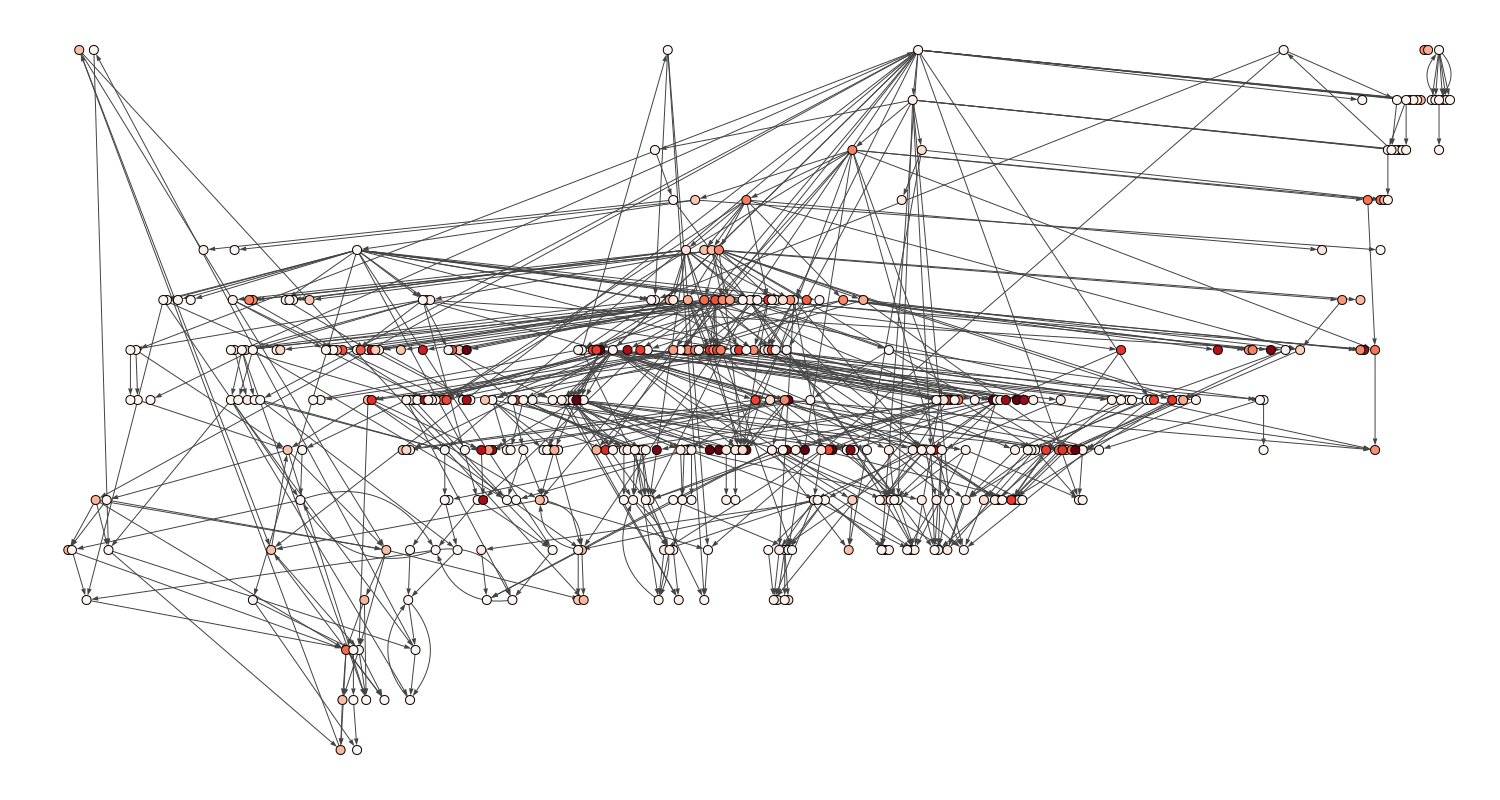

In [1535]:
result_tuples = [(key, value) for key, values in new_parent.items() for value in values]
edges = [(v, k) for k, v in result_tuples]

g = ig.Graph(directed=True)


g.add_vertices(all_clusters2)

g.add_edges(edges)

# layout = g.layout_reingold_tilford()
layout = g.layout_sugiyama()

# annotations = ['Ductal', 'Ductal cells']
# annotations = ['Acinar cells', 'Acinar']
# annotations = ['Epithelial', 'Acinar cells', 'Ductal cells', 'Ductal','Acinar' ]

annotations = ['Immune system cells', 'Mast cells']
proportions = [
    sum(cluster_annotations[clst].get(ann, 0) for ann in annotations)
    for clst in cluster_annotations
]

cmap = plt.get_cmap('Reds')

colors = [cmap(prop) for prop in proportions]

colors_hex = ['#' + ''.join(f'{int(c * 255):02X}' for c in color[:3]) for color in colors]

ig.plot(
    g, 
    layout=layout,
    vertex_color=colors_hex,
    vertex_size=9,
    edge_arrow_size=0.5,
    margin=50,
    # vertex_label_size = 8,
    bbox=(0, 0, 1500, 800),
    
)